In [ ]:
import uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def give_sig_weights(monopole_df):
    file = uproot.open("/home/zhonghua/data/exposure_Gaisser.root")
    h1 = file["h1"]
    h2 = file["h2"]
    # 获取直方图的所有数据
    values = h1.values()        # bin内容（纵坐标）
    h2_values = h2.values()        # bin内容（纵坐标）
    edges = h1.axis().edges()   # bin边界（横坐标）
    h2_edges = h2.axis().edges()   # bin边界（横坐标）
    centers = h1.axis().centers()  # bin中心
    h2_centers = h2.axis().centers()  # bin中心

    values = np.array(h1.values())
    edges = np.array(h1.axis().edges())
    centers = np.array(h1.axis().centers())
    S=np.pi * 1000**2
    parker=1e-15 * 1e4 
    nums=[]
    for i, theta in enumerate(centers):
        cosine_theta = np.cos(np.deg2rad(theta))
        area = S * cosine_theta
        exposure = values[i] * area
        num_i = exposure * parker
        nums.append(num_i)

    weights=[num_i/251000/h2_values[i]/86400 for i, num_i in enumerate(nums)]
    theta_degrees = monopole_df["theta"] * 180 / np.pi
    monopole_weights = []
    for theta in theta_degrees:
        if theta > max(centers) or theta < 0:
            weight = weights[-1] if theta > max(centers) else 0
        else:
            bin_id = np.digitize(theta, edges) - 1
            weight = weights[bin_id]
        monopole_weights.append(weight)
  
    monopole_df["weight"] = monopole_weights
    # print(f"======> Total expected monopole events after weighting: {monopole_df['weight'].sum()} ======")
    return monopole_df

def give_bkg_mc_weights_gaisser(pr_df: pd.DataFrame):
    rootfile = "/home/zhonghua/data/exposure_Gaisser.root"
    with uproot.open(rootfile) as f:
        hWeight = f["hWeight"]
        edges_E = hWeight.axes[0].edges()  # Energy bin edges
        edges_Zen = hWeight.axes[1].edges()  # Zenith bin edges
        weights_2d = hWeight.values()

    def add_weights(trueE, rec_zenith, weights_2d):
        trueE=np.log10(trueE/1e3)
        rec_zenith=180/np.pi*rec_zenith
        bin_idx_E = np.digitize(trueE, edges_E) - 1
        bin_idx_Zen = np.digitize(rec_zenith, edges_Zen) - 1
        if bin_idx_E >= weights_2d.shape[0]:
            bin_idx_E = weights_2d.shape[0] - 1
        if bin_idx_Zen >= weights_2d.shape[1]:
            bin_idx_Zen = weights_2d.shape[1] - 1
        return weights_2d[bin_idx_E, bin_idx_Zen]
    
    pr_df['gaisser_weight']=pr_df.apply(lambda row: add_weights(row['trueE'],row['rec_theta'],weights_2d),axis=1)
    pr_df['gaisser_weight']=pr_df['gaisser_weight']/86400
    # print(f"======> Total expected background MC events after weighting: {pr_df['gaisser_weight'].sum()} ======")
    return pr_df

def give_bkg_mc_weights_horandel(pr_df: pd.DataFrame):
    rootfile = "/home/zhonghua/data/exposure_Horandel.root"
    with uproot.open(rootfile) as f:
        hWeight = f["hWeight"]
        edges_E = hWeight.axes[0].edges()  # Energy bin edges
        edges_Zen = hWeight.axes[1].edges()  # Zenith bin edges
        weights_2d = hWeight.values()

    def add_weights(trueE, rec_zenith, weights_2d):
        trueE=np.log10(trueE/1e3)
        rec_zenith=180/np.pi*rec_zenith
        bin_idx_E = np.digitize(trueE, edges_E) - 1
        bin_idx_Zen = np.digitize(rec_zenith, edges_Zen) - 1
        if bin_idx_E >= weights_2d.shape[0]:
            bin_idx_E = weights_2d.shape[0] - 1
        if bin_idx_Zen >= weights_2d.shape[1]:
            bin_idx_Zen = weights_2d.shape[1] - 1
        return weights_2d[bin_idx_E, bin_idx_Zen]
    
    pr_df['horandel_weight']=pr_df.apply(lambda row: add_weights(row['trueE'],row['rec_theta'],weights_2d),axis=1)
    pr_df['horandel_weight']=pr_df['horandel_weight']/86400
    # print(f"======> Total expected background MC events after weighting: {pr_df['horandel_weight'].sum()} ======")
    return pr_df

def give_exp_weights(exp_df, Ndays):
    exp_df['weight'] = np.ones(len(exp_df)) / Ndays / 86400
    # print(f"======> Total expected exposure events after weighting: {exp_df['weight'].sum()} ======")
    return exp_df




def filter_dataset_optimized(npz_file, output_file=None, mc=True, R_mean_cut=True, is_csv=False, radius_cut=True):
    print("--------------------------------------------------")
    # param_names=["label","gaisser_weight",
    #                 "R_ue", "R_mean", "Eage",
    #                 "recE", "rec_x", "rec_y", "rec_theta", "rec_phi", 
    #                 "trueE", "NuW2", "NpE3", "NuM1", "core_x","core_y","theta"]
    if radius_cut is True:
        r_low=260
        r_high=480
        dr_low=None
        theta_low=0
        theta_high=40 / 180.0 * np.pi

        Rmean_low=25
        Rmean_high=45.0
        Eage_low=0.8
        Eage_high=1.2
        R_ue_high=-5.0
        log10TeV_low=1.8629710674285889
        log10TeV_high=2.2981839179992676
    else:
        # r_low=300
        # r_high=600  
        dr_low=20
        theta_low=0
        theta_high=70 / 180.0 * np.pi

        Rmean_low=25
        Rmean_high=45.0
        Eage_low=0.8
        Eage_high=1.2
        R_ue_high=-5.0
        log10TeV_low=1.8629710674285889
        log10TeV_high=2.2981839179992676

    if not is_csv:
        data = np.load(npz_file, allow_pickle=True)
        params_df = pd.DataFrame(data["params"], columns=data["param_names"])
    else:
        params_df = pd.read_csv(npz_file)
    initial_count = len(params_df)
    current_mask = np.ones(initial_count, dtype=bool)
    
    # asarray re ensure float dtype for calculations
    recE = np.asarray(params_df["recE"].values, dtype=float)
    R_ue = np.asarray(params_df["R_ue"].values, dtype=float)
    R_mean = np.asarray(params_df["R_mean"].values, dtype=float)
    Eage = np.asarray(params_df["Eage"].values, dtype=float)
    rec_theta = np.asarray(params_df["rec_theta"].values, dtype=float)
    rec_phi = np.asarray(params_df["rec_phi"].values, dtype=float)
    rec_x = np.asarray(params_df["rec_x"].values, dtype=float)
    rec_y = np.asarray(params_df["rec_y"].values, dtype=float)
    r = np.sqrt(rec_x**2 + rec_y**2)    
    dr = np.asarray(params_df["dr"].values, dtype=float)
    # -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
    # 顺序筛选与打印比例
    # -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
    print(f"--- 原始数据量: {initial_count} ---")
    

    # 1. 筛选 r (r_low < r < r_high)
    if radius_cut is not True:
        r_mask = (dr > dr_low)
        # r_mask = (r > r_low) & (r < r_high)
        n_last = current_mask.sum()
        current_mask = current_mask & r_mask
        n_after = current_mask.sum()
        print(f"    1. Cut dr: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")
    elif radius_cut is True:
        r_mask = (r > r_low) & (r < r_high)
        n_last = current_mask.sum()
        current_mask = current_mask & r_mask
        n_after = current_mask.sum()
        print(f"    1. Cut r: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    # 2. 筛选 theta (theta_low < theta < theta_high)
    theta_mask = (rec_theta > theta_low) & (rec_theta < theta_high)
    n_last = current_mask.sum()
    current_mask = current_mask & theta_mask
    n_after = current_mask.sum()
    print(f"    2. Cut theta: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    # 0. 筛选 log10TeV (log10TeV_low < recE < log10TeV_high)
    log10TeV_mask = (recE > log10TeV_low) & (recE < log10TeV_high)
    n_last = current_mask.sum()
    current_mask = current_mask & log10TeV_mask
    n_after = current_mask.sum()
    print(f"    0. Cut log10TeV: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")
    
    # 2. 筛选 Eage (Eage_low < Eage < Eage_high)
    Eage_mask = (Eage > Eage_low) & (Eage < Eage_high)
    n_last = current_mask.sum()
    current_mask = current_mask & Eage_mask
    n_after = current_mask.sum()
    print(f"    3. Cut Eage: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")
    
    if R_mean_cut is True:
        # 3. 筛选 R_mean (Rmean_low < R_mean < Rmean_high)
        Rmean_mask = (R_mean > Rmean_low) & (R_mean < Rmean_high)
        n_last = current_mask.sum()
        current_mask = current_mask & Rmean_mask
        n_after = current_mask.sum()
        print(f"    4. Cut R_mean: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    # if not mc:
    #     # 4. 筛选 R_ue (R_ue < R_ue_high)
    #     R_ue_mask = (R_ue < R_ue_high)
    #     n_last = current_mask.sum()
    #     current_mask = current_mask & R_ue_mask
    #     n_after = current_mask.sum()
    #     print(f"5. Cut R_ue: {n_after} / {n_last} (Left Ratio: {n_after/n_last:.2%})")

    # -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
    # 数据保存 (保持与原函数一致)
    # -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
    
    # 打印最终统计信息
    final_count = current_mask.sum()
    print(f"    --- 筛选结果 ---")
    print(f"    原始数据量: {initial_count}")
    print(f"    筛选后数据量: {final_count}")
    print(f"    总通过比例: {final_count/initial_count:.2%}")
    if output_file is not None:
        filtered_data = {}
        keys = data.files
        
        for key in keys:
            if key == "param_names":
                filtered_data[key] = data[key]
            else:
                # 使用布尔掩码直接筛选数组，这是最快的方法
                filtered_data[key] = data[key][current_mask]

    
        output_file = npz_file.replace(".npz", "_cut_loose.npz")
        np.savez(output_file, **filtered_data)
        print(f"筛选后的数据已保存到: {output_file}")
    print("--------------------------------------------------")
    # 关闭文件
    if not is_csv:
        data.close()
    return params_df[current_mask].copy(), params_df


# Index(['label', 'weight', 'R_ue', 'R_mean', 'Eage', 'compactness', 'pincness',
#        'recE', 'rec_x', 'rec_y', 'rec_theta', 'rec_phi', 'NpE3', 'NuM1',
#        'NuM2', 'NuM3', 'NuM4', 'NuM5', 'trueE', 'core_x', 'core_y', 'theta',
#        'phi', 'dr', 'NuW3', 'NuW2'],
#       dtype='object')
# -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
print("Monopole Data Processing...")
mn_npz_file =  "/home/zhonghua/data/Dataset_Filted/Monopole/filted_Monopole_1e10_merged_1000_70_dataset_muon_smooth.npz"
mn_df, mn_df_all = filter_dataset_optimized(mn_npz_file, mc=True)
mn_df = give_sig_weights(mn_df); mn_df_all = give_sig_weights(mn_df_all)

mn_df_large, mn_df_all_large = filter_dataset_optimized(mn_npz_file, mc=True, radius_cut=False)
mn_df_large = give_sig_weights(mn_df_large); mn_df_all_large = give_sig_weights(mn_df_all_large)

mn_df_beforeRmean = filter_dataset_optimized(mn_npz_file, mc=True, R_mean_cut=False)[0]
mn_df_beforeRmean = give_sig_weights(mn_df_beforeRmean)

# -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
print("\nProton Data Processing...")
pr_npz_file = "/home/zhonghua/data/Dataset_Filted/Simulation/1e10_V04/Proton_combined_filted_1e10_V04_dataset_muon.npz"
pr_df, pr_df_all = filter_dataset_optimized(pr_npz_file, mc=True)
pr_df = give_bkg_mc_weights_gaisser(pr_df); pr_df_all = give_bkg_mc_weights_gaisser(pr_df_all)
pr_df = give_bkg_mc_weights_horandel(pr_df); pr_df_all = give_bkg_mc_weights_horandel(pr_df_all)

pr_df_large, pr_df_all_large = filter_dataset_optimized(pr_npz_file, mc=True, radius_cut=False)
pr_df_large = give_bkg_mc_weights_gaisser(pr_df_large); pr_df_all_large = give_bkg_mc_weights_gaisser(pr_df_all_large)
pr_df_large = give_bkg_mc_weights_horandel(pr_df_large); pr_df_all_large = give_bkg_mc_weights_horandel(pr_df_all_large)

pr_df_beforeRmean = filter_dataset_optimized(pr_npz_file, mc=True, R_mean_cut=False)[0]
pr_df_beforeRmean = give_bkg_mc_weights_gaisser(pr_df_beforeRmean); pr_df_beforeRmean = give_bkg_mc_weights_horandel(pr_df_beforeRmean)

# -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
# EPOS_FLUKA pr
print("\nEPOS_FLUKA Proton Data Processing...")
pr_ef_npz_file = "/home/zhonghua/data/Dataset_Filted/CosmicRay/1e10_V04/filted_EF_Proton_4e13_1e15_dataset_muon.npz"
pr_ef_df,_ = filter_dataset_optimized(pr_ef_npz_file, mc=True)
pr_ef_df = give_bkg_mc_weights_gaisser(pr_ef_df); pr_ef_df = give_bkg_mc_weights_horandel(pr_ef_df)

pr_ef_df_beforeRmean = filter_dataset_optimized(pr_ef_npz_file, mc=True, R_mean_cut=False)[0]
pr_ef_df_beforeRmean = give_bkg_mc_weights_gaisser(pr_ef_df_beforeRmean); pr_ef_df_beforeRmean = give_bkg_mc_weights_horandel(pr_ef_df_beforeRmean)

# -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
# QGSJETII_FLUKA pr
print("\nQGSJETII_FLUKA Proton Data Processing...")
pr_qf_npz_file = "/home/zhonghua/data/Dataset_Filted/CosmicRay/1e10_V04/filted_QF_Proton_4e13_1e15_dataset_muon.npz"
pr_qf_df,_ = filter_dataset_optimized(pr_qf_npz_file, mc=True)
pr_qf_df = give_bkg_mc_weights_gaisser(pr_qf_df); pr_qf_df = give_bkg_mc_weights_horandel(pr_qf_df)

pr_qf_df_beforeRmean = filter_dataset_optimized(pr_qf_npz_file, mc=True, R_mean_cut=False)[0]
pr_qf_df_beforeRmean = give_bkg_mc_weights_gaisser(pr_qf_df_beforeRmean); pr_qf_df_beforeRmean = give_bkg_mc_weights_horandel(pr_qf_df_beforeRmean)

# -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
# EPOS QGSJETII weight rescale
# pr_ef_df['gaisser_weight'] = pr_ef_df['gaisser_weight']*QF_allweights_gaisser/pr_ef_df_beforeRmean['gaisser_weight'].sum()
# pr_ef_df['horandel_weight'] = pr_ef_df['horandel_weight']*QF_allweights_horandel/pr_ef_df_beforeRmean['horandel_weight'].sum()
# pr_ef_df_beforeRmean['gaisser_weight']=pr_ef_df_beforeRmean['gaisser_weight']*QF_allweights_gaisser/pr_ef_df_beforeRmean['gaisser_weight'].sum()

# pr_qf_df['gaisser_weight'] = pr_qf_df['gaisser_weight']*QF_allweights_gaisser/pr_qf_df_beforeRmean['gaisser_weight'].sum()
# pr_qf_df['horandel_weight'] = pr_qf_df['horandel_weight']*QF_allweights_horandel/pr_qf_df_beforeRmean['horandel_weight'].sum()
# pr_qf_df_beforeRmean['gaisser_weight']=pr_qf_df_beforeRmean['gaisser_weight']*QF_allweights_gaisser/pr_qf_df_beforeRmean['gaisser_weight'].sum()

# -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
print("\nExperimental Muon Data Processing...")
exp_muon_npz_file = "/home/zhonghua/data/Dataset_Filted/Experiment/exp_muons/2023_0101_1e10_V04_dataset_muon.csv"
exp_muon_df, exp_muon_df_all = filter_dataset_optimized(exp_muon_npz_file, mc=False, is_csv=True)
exp_muon_df = give_exp_weights(exp_muon_df, Ndays=1); exp_muon_df_all = give_exp_weights(exp_muon_df_all, Ndays=1)

exp_muon_df_large, exp_muon_df_all_large = filter_dataset_optimized(exp_muon_npz_file, mc=False, radius_cut=False, is_csv=True)
exp_muon_df_large = give_exp_weights(exp_muon_df_large, Ndays=1); exp_muon_df_all_large = give_exp_weights(exp_muon_df_all_large, Ndays=1)

exp_muon_df_beforeRmean = filter_dataset_optimized(exp_muon_npz_file, mc=False, R_mean_cut=False, is_csv=True)[0]
exp_muon_df_beforeRmean = give_exp_weights(exp_muon_df_beforeRmean, Ndays=1)

# -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
# Exp Rue2_2
print("\nExperimental Rue2_2 Data(2023 339days) Processing...")
exp_muon_Rue2_2_npz_file = "/home/zhonghua/data/Dataset_Filted/Experiment/exp_Rue2_2/2023_1e10_V04_Rue2_2_dataset_muon.csv"
exp_muon_Rue2_2_df, exp_muon_Rue2_2_df_all = filter_dataset_optimized(exp_muon_Rue2_2_npz_file, mc=False, is_csv=True)
exp_muon_Rue2_2_df = give_exp_weights(exp_muon_Rue2_2_df, Ndays=339); exp_muon_Rue2_2_df_all = give_exp_weights(exp_muon_Rue2_2_df_all, Ndays=339)

exp_muon_Rue2_2_df_large, exp_muon_Rue2_2_df_all_large = filter_dataset_optimized(exp_muon_Rue2_2_npz_file, mc=False, radius_cut=False, is_csv=True)
exp_muon_Rue2_2_df_large = give_exp_weights(exp_muon_Rue2_2_df_large, Ndays=339); exp_muon_Rue2_2_df_all_large = give_exp_weights(exp_muon_Rue2_2_df_all_large, Ndays=339)

# -------------------------------------------------- --------------------------------------------------  --------------------------------------------------
print(f"Monopole ={mn_df['weight'].sum()}")
print(f"Proton Gaisser={pr_df['gaisser_weight'].sum()}, Horandel={pr_df['horandel_weight'].sum()}")
print(f"Proton EPOS_FLUKA Gaisser={pr_ef_df['gaisser_weight'].sum()}, Horandel={pr_ef_df['horandel_weight'].sum()}")
print(f"Proton QGSJETII_FLUKA Gaisser={pr_qf_df['gaisser_weight'].sum()}, Horandel={pr_qf_df['horandel_weight'].sum()}")
print(f"Experimental Muon ={exp_muon_df['weight'].sum()}")
print(f"Experimental Rue2_2 ={exp_muon_Rue2_2_df['weight'].sum()}")

print("\nLarge Radius Cut:")
print(f"Monopole ={mn_df_large['weight'].sum()}")
print(f"Proton Gaisser={pr_df_large['gaisser_weight'].sum()}, Horandel={pr_df_large['horandel_weight'].sum()}")
print(f"Experimental Muon ={exp_muon_df_large['weight'].sum()}")
print(f"Experimental Rue2_2 ={exp_muon_Rue2_2_df_large['weight'].sum()}")


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

# ==========================================
# 1. 数据加载与预处理工具
# ==========================================

def load_full_data(file: str) -> pd.DataFrame:
    """
    加载完整的 npz 数据，返回包含所有 params 的 DataFrame。
    """
    print(f"Loading: {file}")
    # 如果是npz文件
    if file.endswith('.npz'):
        data = np.load(file, allow_pickle=True)
        # 使用 param_names 作为列名构建完整 DataFrame
        df = pd.DataFrame(data["params"], columns=data["param_names"])
    # 如果是csv文件
    elif file.endswith('.csv'):
        df = pd.read_csv(file)
    return df

def prepare_data(sig_file, bkg_file, test_files_dict, features, test_size=0.2, seed=42):
    """
    准备训练、验证和测试数据。
    同时返回用于保存 CSV 的原始 DataFrame (仅 Val 和 Test，不含 Train)。
    """
    # 1. 加载完整数据
    df_sig = load_full_data(sig_file)
    df_bkg = load_full_data(bkg_file)
    
    # 检查特征是否存在
    for f in features:
        if f not in df_sig.columns:
            raise ValueError(f"Feature {f} missing in signal file")
        if f not in df_bkg.columns:
            raise ValueError(f"Feature {f} missing in background file")

    # 创建 Label
    y_sig = np.ones(len(df_sig))
    y_bkg = np.zeros(len(df_bkg))
    
    # 合并 DataFrame 和 Label
    df_all = pd.concat([df_sig, df_bkg], axis=0).reset_index(drop=True)
    y_all = np.concatenate([y_sig, y_bkg], axis=0)
    
    # 提取训练所需的特征矩阵 X
    X_all = df_all[features].values
    
    # 划分 Train / Val
    # 注意：这里我们同时划分 X(特征), y(标签) 和 df_all(原始完整数据)
    # random_state 保证了 X 和 df 的划分索引是一一对应的
    X_train, X_val, y_train, y_val, _, df_val = train_test_split(
        X_all, y_all, df_all, test_size=test_size, random_state=seed, stratify=y_all
    )
    
    # 2. 加载外部测试数据
    # test_data 结构: { 'name': (X_matrix, full_DataFrame) }
    test_data = {}
    for name, path in test_files_dict.items():
        df_temp = load_full_data(path)
        X_temp = df_temp[features].values
        test_data[name] = (X_temp, df_temp)
        
    return X_train, y_train, X_val, y_val, df_val, test_data

def save_to_csv(df_original, scores, out_dir, filename):
    """
    将原始数据与模型评分合并并保存为 CSV
    """
    os.makedirs(out_dir, exist_ok=True)
    save_path = os.path.join(out_dir, filename)
    
    # 避免修改原始内存中的 df，创建副本
    df_save = df_original.copy()
    
    # 添加模型分数
    df_save['model_score'] = scores
    
    # 保存
    print(f"Saving CSV: {save_path}")
    df_save.to_csv(save_path, index=False, float_format='%.6g')

# ==========================================
# 2. 绘图函数 (保持不变)
# ==========================================
def plot_score_distributions(val_dict, test_dict, out_dir, model_name):
    """
    val_dict: {'sig': scores, 'bkg': scores}
    test_dict: {'EF': scores, 'QF': scores, ...}
    """
    os.makedirs(out_dir, exist_ok=True)
    
    bins = np.linspace(0, 1, 11) # 稍微增加一点bin数使其更平滑
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    hist_val_bkg, _ = np.histogram(val_dict['bkg'], bins=bins, density=True)
    hist_base = hist_val_bkg.copy()
    hist_base[hist_base == 0] = np.nan
    
    fig, (ax_main, ax_ratio) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, 
                                            gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.05})
    
    colors = ['tab:blue', 'tab:green', 'tab:orange', 'tab:purple', 'tab:red']
    
    # --- PDF ---
    ax_main.hist(val_dict['sig'], bins=bins, density=True, histtype='step', 
                 color='red', linestyle='--', linewidth=1.5, label='Val Sig PDF')
    
    ax_main.hist(bins[:-1], bins, weights=hist_val_bkg, histtype='step', 
                 color='black', linestyle='--', linewidth=1.5, label='Val Bkg PDF')
    
    for i, (name, scores) in enumerate(test_dict.items()):
        color = colors[i % len(colors)]
        hist_curr, _ = np.histogram(scores, bins=bins, density=True)
        ax_main.hist(bins[:-1], bins, weights=hist_curr, histtype='step', 
                     alpha=0.3, color=color, label=f"{name} (PDF)")
        ax_main.hist(bins[:-1], bins, weights=hist_curr, histtype='step', 
                     linewidth=1, color=color)
        
        ratio = hist_curr / hist_base
        ax_ratio.step(bin_centers, ratio, where='mid', color=color, linewidth=1.5)

    # --- CDF ---
    ax_cdf = ax_main.twinx()
    sig_sorted = np.sort(val_dict['sig'])
    y_sig = np.arange(1, len(sig_sorted) + 1) / len(sig_sorted)
    ax_cdf.plot(sig_sorted, y_sig, color='red', linestyle='--', alpha=0.3, linewidth=2, label='Val Sig CDF')

    bkg_sorted = np.sort(val_dict['bkg'])
    y_bkg = 1.0 - np.arange(1, len(bkg_sorted) + 1) / len(bkg_sorted)
    ax_cdf.plot(bkg_sorted, y_bkg, color='black', linestyle='--', alpha=0.3, linewidth=2, label='Val Bkg Surv')

    ax_main.set_ylabel("Density")
    # ax_main.set_yscale('log') # Log scale 经常更好看
    ax_main.set_title(f"{model_name} Score Distributions")
    ax_main.legend(loc='upper center', ncol=2, frameon=False, fontsize=10)
    ax_main.grid(alpha=0.3)
    
    ax_cdf.set_ylabel("Probability")
    ax_cdf.set_ylim(0, 1.05)
    
    ax_ratio.axhline(1, color='black', linestyle='--', alpha=0.5) 
    ax_ratio.set_ylabel("Ratio / Val Bkg")
    ax_ratio.set_xlabel("Model Score")
    ax_ratio.set_ylim(0, 3) 
    ax_ratio.grid(alpha=0.3)
    
    save_path = os.path.join(out_dir, f"{model_name}_dist.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()
    print(f"Plot saved to {save_path}")

# ==========================================
# 3. 模型定义与运行函数
# ==========================================

# --- XGBoost ---
def run_xgboost(X_train, y_train, X_val, y_val, df_val, test_data, out_dir):
    print("\n=== Training XGBoost ===")
    
    clf = xgb.XGBClassifier(
        n_estimators=200, 
        learning_rate=0.1, 
        max_depth=5, 
        eval_metric="logloss",
        use_label_encoder=False,
        tree_method='hist',
        device='cpu'
    )
    
    clf.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    
    # --- 验证集预测与保存 ---
    val_probs = clf.predict_proba(X_val)[:, 1]
    
    # 保存 Validation CSV
    save_to_csv(df_val, val_probs, out_dir, "validation_set_xgb.csv")
    
    val_dict = {
        'sig': val_probs[y_val == 1],
        'bkg': val_probs[y_val == 0]
    }
    
    # --- 测试集预测与保存 ---
    test_dict = {}
    for name, (X_test, df_test) in test_data.items():
        probs = clf.predict_proba(X_test)[:, 1]
        test_dict[name] = probs
        
        # 保存 Test CSV
        csv_name = f"{name}_xgb.csv"
        save_to_csv(df_test, probs, out_dir, csv_name)
        
    plot_score_distributions(val_dict, test_dict, out_dir, model_name="XGBoost")
    return clf

# --- MLP (PyTorch) ---
class SimpleMLP(nn.Module):
    def __init__(self, in_dim, hidden_dim=128):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.net(x)

def run_mlp(X_train, y_train, X_val, y_val, df_val, test_data, out_dir, device='cuda'):
    print("\n=== Training MLP ===")
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    train_dataset = TensorDataset(torch.FloatTensor(X_train_scaled), torch.FloatTensor(y_train).unsqueeze(1))
    train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
    
    model = SimpleMLP(in_dim=X_train.shape[1]).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.BCELoss()
    
    epochs = 30
    model.train()
    for epoch in range(epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    model.eval()
    
    # --- 验证集预测与保存 ---
    with torch.no_grad():
        X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
        val_probs = model(X_val_tensor).cpu().numpy().flatten()
    
    # 保存 Validation CSV (注意：这里保存的是df_val原始值，不是scaler处理后的)
    save_to_csv(df_val, val_probs, out_dir, "validation_set_mlp.csv")
        
    val_dict = {
        'sig': val_probs[y_val == 1],
        'bkg': val_probs[y_val == 0]
    }
    
    # --- 测试集预测与保存 ---
    test_dict = {}
    with torch.no_grad():
        for name, (X_test, df_test) in test_data.items():
            X_test_scaled = scaler.transform(X_test)
            X_tensor = torch.FloatTensor(X_test_scaled).to(device)
            probs = model(X_tensor).cpu().numpy().flatten()
            test_dict[name] = probs
            
            # 保存 Test CSV
            csv_name = f"{name}_mlp.csv"
            save_to_csv(df_test, probs, out_dir, csv_name)
            
    plot_score_distributions(val_dict, test_dict, out_dir, model_name="MLP")
    return model

# ==========================================
# Main Execution
# ==========================================
if __name__ == "__main__":
    # 路径配置
    sig_file = "/home/zhonghua/data/Dataset_Filted/filted_Monopole_1e10_merged_1000_70_new_dataset_loose.npz"
    pr_file  = "/home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/Proton_1000_70_1e10_V03_dataset_loose.npz"
    
    test_files = {
        "EF_Model": "/home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/0818_filted_EF_Proton_4e13_1e15_dataset_loose.npz",
        "QF_Model": "/home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/0818_filted_QF_Proton_4e13_1e15_dataset_loose.npz",
        "Exp_2022": "/home/zhonghua/data/Dataset_Filted/Experiment/2022/all_combined_2022_dataset_1e10_for_diffmodels_loose_300_500.npz",
        "QG_large": "/home/zhonghua/data/Dataset_Filted/CosmicRay/Npz/Proton_1000_70_1e10_V03_dataset_loose_300_500.npz",
        "Monopole_large": "/home/zhonghua/data/Dataset_Filted/filted_Monopole_1e10_merged_1000_70_new_dataset_loose_300_500.npz",
    }
    
    # 特征列表'R_mean', 'rec_phi'
    feature_cols = ['Eage', 'rec_theta', ]
    output_dir = "/home/zhonghua/Filt_Event/model_validation/xgb_mlp"
    
    device = "cpu" # 如果有GPU可改为 "cuda"
    
    # 1. 准备数据
    print("Preparing data...")
    # 注意：prepare_data 现在返回 df_val 和 test_data (包含完整df)
    X_train, y_train, X_val, y_val, df_val, test_data = prepare_data(
        sig_file, pr_file, test_files, feature_cols
    )
    print(f"Train size: {X_train.shape[0]}, Val size: {X_val.shape[0]}")
    
    # 2. 运行 XGBoost (会自动保存CSV)
    run_xgboost(X_train, y_train, X_val, y_val, df_val, test_data, output_dir)
    
    # # 3. 运行 MLP (会自动保存CSV)
    # run_mlp(X_train, y_train, X_val, y_val, df_val, test_data, output_dir, device=device)
    
    print("\nAll Done.")


In [71]:
import numpy as np
import pandas as pd
import xgboost as xgb
import uproot
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
# ==========================================
# 1. 配置与物理工具类 (Physics Tools)
# ==========================================

class PhysicsConfig:
    # 你的 ROOT 文件路径
    ROOT_GAISSER = "/home/zhonghua/data/exposure_Gaisser.root"
    ROOT_HORANDEL = "/home/zhonghua/data/exposure_Horandel.root"
    
    # 训练用的特征列表
    TRAIN_FEATURES = ['Eage', 'rec_theta', 'R_mean', 'rec_phi', 'compactness', 'pincness'] # 可以在这里添加更多，如 'log10_recE' 等

class PhysicsWeighter:
    """处理物理权重的类"""
    
    @staticmethod
    def get_exposure_hist(root_file, hist_name):
        with uproot.open(root_file) as f:
            h = f[hist_name]
            return h.values(), h.axis().edges(), h.axis().centers()

    @staticmethod
    def get_2d_weight_map(root_file, hist_name):
        with uproot.open(root_file) as f:
            h = f[hist_name]
            return h.values(), h.axes[0].edges(), h.axes[1].edges()

    @staticmethod
    def give_sig_weights(df):
        """Monopole 信号加权"""
        vals, edges, centers = PhysicsWeighter.get_exposure_hist(PhysicsConfig.ROOT_GAISSER, "h1")
        h2_vals, _, _ = PhysicsWeighter.get_exposure_hist(PhysicsConfig.ROOT_GAISSER, "h2")
        
        S = np.pi * 1000**2
        parker = 1e-15 * 1e4 
        
        # 预计算 exposure weights
        exposure_weights = []
        for i, theta in enumerate(centers):
            cosine_theta = np.cos(np.deg2rad(theta))
            area = S * cosine_theta
            num_i = vals[i] * area * parker
            # 这里的归一化系数保留你原代码的逻辑
            exposure_weights.append(num_i / 251000 / h2_vals[i] / 86400)
            
        exposure_weights = np.array(exposure_weights)
        
        # 向量化计算
        theta_deg = df["rec_theta"].values * 180 / np.pi # 注意：原代码用的 theta 还是 rec_theta? 你原代码混用了，这里假设用 rec_theta
        # 如果原代码是用 true theta (theta列)，请改为 df['theta']
        
        # 处理 bin index
        # 注意：np.digitize 返回 1-based index, weights 是 0-based
        bin_indices = np.digitize(theta_deg, edges) - 1
        
        # 处理边界
        n_bins = len(exposure_weights)
        weights = np.zeros(len(df))
        
        valid_mask = (bin_indices >= 0) & (bin_indices < n_bins)
        weights[valid_mask] = exposure_weights[bin_indices[valid_mask]]
        
        # 溢出处理 (按照你原代码逻辑，大于最大值的取最后一个bin)
        weights[theta_deg > edges[-1]] = exposure_weights[-1]
        
        df["weight"] = weights
        return df

    @staticmethod
    def give_bkg_mc_weights(df, model='gaisser'):
        """Proton 背景 MC 加权"""
        root_file = PhysicsConfig.ROOT_GAISSER if model == 'gaisser' else PhysicsConfig.ROOT_HORANDEL
        w_vals, edges_E, edges_Zen = PhysicsWeighter.get_2d_weight_map(root_file, "hWeight")
        
        trueE_log = np.log10(df['trueE'].values / 1e3)
        rec_zen = df['rec_theta'].values * 180 / np.pi
        
        # 向量化 bin 查找
        idx_E = np.clip(np.digitize(trueE_log, edges_E) - 1, 0, w_vals.shape[0] - 1)
        idx_Zen = np.clip(np.digitize(rec_zen, edges_Zen) - 1, 0, w_vals.shape[1] - 1)
        
        weights = w_vals[idx_E, idx_Zen] / 86400
        
        col_name = f'{model}_weight'
        df[col_name] = weights
        return df

    @staticmethod
    def give_exp_weights(df, Ndays):
        df['weight'] = 1.0 / Ndays / 86400
        return df

# ==========================================
# 2. 数据加载与筛选 (Data Processor)
# ==========================================

def load_and_filter(file_path, mc_proton=False, radius_cut=True, is_csv=False, R_mean_cut=True):
    """
    加载数据并应用筛选 Cuts。
    """
    print(f"loading: {os.path.basename(file_path)} | LargeRange: {not radius_cut}")
    
    # 1. Load Data
    if is_csv or file_path.endswith('.csv'):
        df = pd.read_csv(file_path)
    else:
        # 处理 npz
        with np.load(file_path, allow_pickle=True) as data:
            if 'params' in data and 'param_names' in data:
                df = pd.DataFrame(data['params'], columns=data['param_names'])
            else:
                # 兼容某些没有 param_names 的情况，或者由 key 直接构成
                keys = [k for k in data.files if k != 'param_names']
                df = pd.DataFrame({k: data[k] for k in keys})

    # 2. Define Cuts Parameters
    # 默认使用 Large 范围参数，如果 radius_cut=True 则缩小范围
    # 注意：根据你的描述，训练集用 Large (radius_cut=False)
    df['rec_theta'] = pd.to_numeric(df['rec_theta'], errors='coerce')
    df['Eage'] = pd.to_numeric(df['Eage'], errors='coerce')
    df['R_mean'] = pd.to_numeric(df['R_mean'], errors='coerce')
    df['recE'] = pd.to_numeric(df['recE'], errors='coerce')
    df['rec_x'] = pd.to_numeric(df['rec_x'], errors='coerce')
    df['rec_y'] = pd.to_numeric(df['rec_y'], errors='coerce')
    df['dr'] = pd.to_numeric(df['dr'], errors='coerce')
    df['trueE'] = pd.to_numeric(df['trueE'], errors='coerce')
    rec_theta_deg = df['rec_theta'] * 180 / np.pi
    r = np.sqrt(df['rec_x']**2 + df['rec_y']**2)
    
    # 是大范围proton数据
    if mc_proton and (not radius_cut):
        df['R_mean'] = df['R_mean']-2.278
        
    if radius_cut:
        r_range = (260, 480)
        theta_range = (0, 40) # degree
    else:
        r_range = None # 不切 R (或者用 dr 切)
        theta_range = (0, 70) # degree
    
    logE_range = (1.86297, 2.29818)
    Eage_range = (0.85, 1.15)
    Rmean_range = (28, 45)
    
    # 3. Apply Filters
    mask = np.ones(len(df), dtype=bool)
    
    # 3.0 Convert necessary columns
    

    # 3.1 Log10TeV Cut
    mask &= (df['recE'] > logE_range[0]) & (df['recE'] < logE_range[1])
    
    # 3.2 Theta Cut
    mask &= (rec_theta_deg > theta_range[0]) & (rec_theta_deg < theta_range[1])
    
    # 3.3 Eage Cut
    mask &= (df['Eage'] > Eage_range[0]) & (df['Eage'] < Eage_range[1])
    
    # 3.4 Radius Cut
    if radius_cut:
        mask &= (r > r_range[0]) & (r < r_range[1])
    else:
        # Large Range 逻辑: 使用 dr 切割
        if 'dr' in df.columns:
            mask &= (df['dr'] > 0)
    
    # 3.5 R_mean Cut
    if R_mean_cut:
        mask &= (df['R_mean'] > Rmean_range[0]) & (df['R_mean'] < Rmean_range[1])
        
    df_filtered = df[mask].copy().reset_index(drop=True)
    
    # 4. Cleanup
    # 简单的内存管理，确保类型正确
    cols_to_float = ['rec_theta', 'Eage', 'R_mean', 'recE', 'rec_x', 'rec_y']
    for c in cols_to_float:
        if c in df_filtered.columns:
            df_filtered[c] = df_filtered[c].astype(float)
            
    return df_filtered

# ==========================================
# 3. 核心流程管理器 (Manager)
# ==========================================

def prepare_datasets(file_dict, feature_cols):
    """
    准备所有数据：训练集（大范围）和测试集列表
    file_dict: 包含路径配置
    """
    datasets = {}
    R_ue_cut = -2.53

    # --- 1. 训练集构建 (Train Set: Large Range) ---
    print("\n=== Processing Training Data (Large Range) ===")
    
    # Signal: Monopole Large
    df_sig = load_and_filter(file_dict['sig_path'], mc_proton=False, radius_cut=False, is_csv=False)
    df_sig = PhysicsWeighter.give_sig_weights(df_sig)
    df_sig['label'] = 1
    df_sig=df_sig[df_sig['R_ue']<R_ue_cut]
    # 此时 df_sig['weight'] 是物理权重
    
    # Background: Proton Large (Baseline)
    df_bkg = load_and_filter(file_dict['bkg_path'], mc_proton=True, radius_cut=False, is_csv=False)
    df_bkg = PhysicsWeighter.give_bkg_mc_weights(df_bkg, 'gaisser')
    df_bkg['weight'] = df_bkg['gaisser_weight'] # 统一列名
    df_bkg['label'] = 0
    
    # 合并训练数据
    df_train_full = pd.concat([df_sig, df_bkg], ignore_index=True)
    
    # 划分 Train/Val
    # 注意：这里我们保留所有列，因为后面可能要画物理分布
    train_df, val_df = train_test_split(
        df_train_full, test_size=0.2, random_state=42, stratify=df_train_full['label']
    )
    
    datasets['train'] = train_df
    datasets['val'] = val_df
    
    # --- 2. 测试集构建 (Test Sets) ---
    print("\n=== Processing Test Data ===")
    test_sets = {}
    
    # Helper to process test files
    def process_test(key, path, is_mc, is_csv, w_func, cut_r=True):
        df = load_and_filter(path, mc_proton=is_mc, radius_cut=cut_r, is_csv=is_csv)
        if w_func:
            df = w_func(df)
            # 统一权重列名，方便画图
            if 'gaisser_weight' in df.columns and 'weight' not in df.columns:
                df['weight'] = df['gaisser_weight']
        return df

    # EF Model (Proton)
    test_sets['QG_Proton_small'] = process_test('QG', file_dict['qg_path'], True, False, 
                                          lambda d: PhysicsWeighter.give_bkg_mc_weights(d, 'gaisser'))

    test_sets['EF_Proton_small'] = process_test('EF', file_dict['ef_path'], True, False, 
                                          lambda d: PhysicsWeighter.give_bkg_mc_weights(d, 'gaisser'))
    
    # QF Model (Proton)
    test_sets['QF_Proton_small'] = process_test('QF', file_dict['qf_path'], True, False, 
                                          lambda d: PhysicsWeighter.give_bkg_mc_weights(d, 'gaisser'))
    
    # # Exp Muon (Small Range, Ndays=1 for example)
    # test_sets['Exp_Muon'] = process_test('Exp', file_dict['exp_path'], False, True, 
    #                                      lambda d: PhysicsWeighter.give_exp_weights(d, Ndays=1))
    
    # Exp Rue2_2 (Small Range, Ndays=339)
    test_sets['Exp_Rue2_2'] = process_test('Rue', file_dict['rue_path'], False, True, 
                                           lambda d: PhysicsWeighter.give_exp_weights(d, Ndays=364), cut_r=False)
    test_sets['Exp_Rue2_2'] = test_sets['Exp_Rue2_2'][test_sets['Exp_Rue2_2']['R_ue']<R_ue_cut]
    # 如果需要大范围的 Exp 数据作为测试，也可以加在这里
    # test_sets['Exp_Muon_Large'] = ...
    
    datasets['tests'] = test_sets
    return datasets

# ==========================================
# 4. 模型训练与评估
# ==========================================

class SimpleMLP(nn.Module):
    def __init__(self, input_dim):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            # 第一层
            nn.Linear(input_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            # 第二层
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            # 第三层
            nn.Linear(64, 32),
            nn.ReLU(),
            
            # 输出层
            nn.Linear(32, 1),
            nn.Sigmoid() # 输出 0-1 概率
        )
        
    def forward(self, x):
        return self.net(x)
# def train_and_predict_(datasets, features, model_type='xgb'):
#     """
#     训练模型并对所有数据集进行预测，将 score 写入 DataFrame
#     """
#     print(f"\n=== Training {model_type.upper()} Model ===")
    
#     df_train = datasets['train']
#     df_val = datasets['val']
    
#     X_train = df_train[features].values
#     y_train = df_train['label'].values
#     # 获取物理权重
#     w_train_phys = df_train['weight'].values
    
#     X_val = df_val[features].values
#     y_val = df_val['label'].values
#     w_val_phys = df_val['weight'].values
    
#     # --- 关键：训练权重归一化 ---
#     # XGBoost 对权重非常敏感。如果物理权重是 1e-15 级别，梯度会消失。
#     # 我们需要将权重归一化，使得 sum(w_pos) approx sum(w_neg) approx N_samples
    
#     def get_norm_weights(y, w):
#         w_norm = w.copy()
#         sum_pos = np.sum(w[y==1])
#         sum_neg = np.sum(w[y==0])
#         # 避免除以0
#         if sum_pos == 0: sum_pos = 1
#         if sum_neg == 0: sum_neg = 1
        
#         # 将两类总权重都缩放到 10000 (或者样本数的一半)
#         scale_pos = 10000.0 / sum_pos
#         scale_neg = 10000.0 / sum_neg
        
#         w_norm[y==1] *= scale_pos
#         w_norm[y==0] *= scale_neg
#         return w_norm
    
#     w_train_norm = get_norm_weights(y_train, w_train_phys)
#     w_val_norm = get_norm_weights(y_val, w_val_phys)
    
#     model = None
    
#     if model_type == 'xgb':
#         model = xgb.XGBClassifier(
#             n_estimators=600,
#             learning_rate=0.05,
#             max_depth=4,
#             eval_metric="logloss",
#             device='cpu' # 或 cuda
#         )
        
#         model.fit(
#             X_train, y_train, 
#             sample_weight=w_train_norm,
#             eval_set=[(X_train, y_train), (X_val, y_val)],
#             sample_weight_eval_set=[w_train_norm, w_val_norm],
#             verbose=50
#         )
        
#     # --- 预测 ---
#     print("Predicting on all datasets...")
    
#     # 1. Validation Set
#     datasets['val']['score'] = model.predict_proba(X_val)[:, 1]
    
#     # 2. Test Sets
#     for name, df in datasets['tests'].items():
#         X_test = df[features].values
#         df['score'] = model.predict_proba(X_test)[:, 1]
        
#     return model, datasets

def train_and_predict(datasets, features, model_type='xgb', device='cpu'):
    """
    训练模型并对所有数据集进行预测，将 score 写入 DataFrame
    支持 model_type: 'xgb', 'mlp'
    """
    print(f"\n=== Training {model_type.upper()} Model ===")
    
    df_train = datasets['train']
    df_val = datasets['val']
    
    X_train = df_train[features].values
    y_train = df_train['label'].values
    w_train_phys = df_train['weight'].values
    
    X_val = df_val[features].values
    y_val = df_val['label'].values
    w_val_phys = df_val['weight'].values
    
    # --- 权重归一化 ---
    def get_norm_weights(y, w):
        w_norm = w.copy()
        sum_pos = np.sum(w[y==1])
        sum_neg = np.sum(w[y==0])
        if sum_pos == 0: sum_pos = 1
        if sum_neg == 0: sum_neg = 1
        
        scale_pos = 10000.0 / sum_pos
        scale_neg = 10000.0 / sum_neg
        
        w_norm[y==1] *= scale_pos
        w_norm[y==0] *= scale_neg
        return w_norm
    
    w_train_norm = get_norm_weights(y_train, w_train_phys)
    w_val_norm = get_norm_weights(y_val, w_val_phys)
    
    model = None
    scaler = None # 仅用于 MLP
    
    # ==========================================
    # Branch 1: XGBoost
    # ==========================================
    if model_type == 'xgb':
        model = xgb.XGBClassifier(
            n_estimators=600,
            learning_rate=0.05,
            max_depth=5,
            eval_metric="logloss",
            # tree_method='hist', # 如果数据量大建议开启
            device=device if device != 'cpu' else 'cpu'
        )
        
        model.fit(
            X_train, y_train, 
            sample_weight=w_train_norm,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            sample_weight_eval_set=[w_train_norm, w_val_norm],
            verbose=100
        )

    # ==========================================
    # Branch 2: MLP (PyTorch)
    # ==========================================
    elif model_type == 'mlp':
        # 1. 数据标准化 (神经网络必须步骤)
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val) # 使用训练集的参数转换验证集
        
        # 2. 转换为 Tensor
        # 注意：这里把 weight 也放进 TensorDataset，以便在 batch 训练中对应
        t_X_train = torch.tensor(X_train_scaled, dtype=torch.float32).to(device)
        t_y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)
        t_w_train = torch.tensor(w_train_norm, dtype=torch.float32).unsqueeze(1).to(device)
        
        t_X_val = torch.tensor(X_val_scaled, dtype=torch.float32).to(device)
        t_y_val = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)
        
        train_ds = TensorDataset(t_X_train, t_y_train, t_w_train)
        train_loader = DataLoader(train_ds, batch_size=512, shuffle=True)
        
        # 3. 初始化模型
        model = SimpleMLP(input_dim=len(features)).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
        # reduction='none' 允许我们手动乘以样本权重
        criterion = nn.BCELoss(reduction='none') 
        
        # 4. 训练循环
        epochs = 50
        print(f"Starting MLP training on {device} for {epochs} epochs...")
        
        for epoch in range(epochs):
            model.train()
            total_loss = 0
            
            for xb, yb, wb in train_loader:
                optimizer.zero_grad()
                pred = model(xb)
                
                # 计算加权 Loss
                loss_raw = criterion(pred, yb)
                loss_weighted = (loss_raw * wb).mean() # 关键：乘以归一化权重
                
                loss_weighted.backward()
                optimizer.step()
                total_loss += loss_weighted.item()
            
            # 简单的验证集监控
            if (epoch+1) % 10 == 0:
                model.eval()
                with torch.no_grad():
                    val_pred = model(t_X_val)
                    val_loss = criterion(val_pred, t_y_val).mean().item() # 验证集简单看均值即可
                print(f"Epoch {epoch+1}/{epochs} | Train Loss: {total_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f}")

    # ==========================================
    # Prediction Phase
    # ==========================================
    print("Predicting on all datasets...")
    
    # 辅助函数：根据模型类型预测
    def get_probs(model_obj, X_in, scaler_obj=None):
        if model_type == 'xgb':
            return model_obj.predict_proba(X_in)[:, 1]
        elif model_type == 'mlp':
            model_obj.eval()
            # MLP 需要先 Scale，再转 Tensor
            X_scaled = scaler_obj.transform(X_in)
            X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
            with torch.no_grad():
                probs = model_obj(X_tensor).cpu().numpy().flatten()
            return probs

    # 1. Validation Set
    datasets['val']['score'] = get_probs(model, X_val, scaler)
    
    # 2. Test Sets
    for name, df in datasets['tests'].items():
        X_test = df[features].values
        # 注意：这里会自动复用 scaler (如果是 MLP)
        df['score'] = get_probs(model, X_test, scaler)
        
    return model, datasets

# ==========================================
# 5. 绘图 (Weighted)
# ==========================================

def plot_weighted_scores(datasets, output_dir, bin_num=50):
    """
    画加权后的 Score 分布图 (含 Ratio 子图，以 Proton Val 为基准)
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # 提取数据
    df_val = datasets['val']
    
    # Sig (Val)
    val_sig = df_val[df_val['label'] == 1]
    # Bkg (Val - Proton Baseline)
    val_bkg = df_val[df_val['label'] == 0]
    
    # 设置 Bins
    
    bins = np.linspace(0, 1, bin_num + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    # 创建画布：两个子图 (Main + Ratio)
    # height_ratios=[3, 1] 让主图占 3/4，Ratio 占 1/4
    # hspace=0.05 让两个图紧贴在一起
    fig, (ax_main, ax_ratio) = plt.subplots(
        2, 1, 
        figsize=(10, 10), 
        sharex=True, 
        gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.05}
    )
    
    # ==============================
    # 1. 计算基准 (Background Val)
    # ==============================
    # 计算 Proton Val 的直方图 (density=True)
    hist_bkg, _ = np.histogram(val_bkg['score'], bins=bins, weights=val_bkg['weight'], density=True)
    
    # 处理分母为0的情况，避免除法报错 (将0替换为nan)
    hist_base = hist_bkg.copy()
    hist_base[hist_base == 0] = np.nan 
    
    

    # 画基准线 (Main Plot)
    ax_main.hist(bins[:-1], bins, weights=hist_bkg, 
                 histtype='step', color='black', lw=2, label='Background (Proton Val)', linestyle='-')
    
    # ==============================
    # 2. 画 Signal (Val)
    # ==============================
    hist_sig, _ = np.histogram(val_sig['score'], bins=bins, weights=val_sig['weight'], density=True)
    
    # Main Plot
    ax_main.hist(bins[:-1], bins, weights=hist_sig, 
                 histtype='step', color='red', lw=2, label='Signal (Monopole Val)', linestyle='-')
    
    # Ratio Plot (Sig / Bkg) 
    # 虽然物理上 Sig/Bkg 意义不同，但这里为了看分布形状差异，也画出来
    ratio_sig = hist_sig / hist_base
    ax_ratio.step(bin_centers, ratio_sig, where='mid', color='red', lw=1, alpha=0.5, linestyle='-')

    # ==============================
    # 3. 画 Test Sets并计算 Ratio
    # ==============================
    colors = ['blue', 'green', 'orange', 'purple', 'magenta']
    test_sets = datasets['tests']
    # small QG
    hist_QG = np.histogram(test_sets['QG_Proton_small']['score'], bins=bins, weights=test_sets['QG_Proton_small']['weight'], density=True)[0]
    hist_QG[hist_QG == 0] = np.nan # 处理分母为0的情况

    ratio_small_diffs = {'QF_Proton_small': [], 'EF_Proton_small': [], 'QG_Proton_small': np.ones(bin_num)}

    for i, (name, df) in enumerate(test_sets.items()):
        c = colors[i % len(colors)]
        
        # 计算当前数据的直方图 (density=True)
        hist_curr, _ = np.histogram(df['score'], bins=bins, weights=df['weight'], density=True)
        
        # Main Plot
        linestyle = ':'; histtype = 'step'; alpha=1
        if name not in ['QG_Proton_small', 'EF_Proton_small', 'QF_Proton_small']:
            linestyle = '-'; histtype = 'stepfilled'; alpha=0.2
        if name == 'QG_Proton_small':
            c='black'

        if name in ['QF_Proton_small', 'EF_Proton_small']:
            ratio = hist_curr / hist_QG
            print(len(hist_curr), bin_num)
            ax_main.hist(bins[:-1], bins, weights=hist_curr, 
                     histtype=histtype, linestyle=linestyle, color=c, label=f'{name}', alpha=alpha, lw=1.5)
            # Ratio Plot (Current / Proton_Val)
            ax_ratio.step(bin_centers, ratio, where='mid', color=c, lw=1.5, linestyle=linestyle,)
            ratio_small_diffs[name]= ratio

        elif name == 'QG_Proton_small':
            ax_main.hist(bins[:-1], bins, weights=hist_curr, 
                        histtype=histtype, linestyle=linestyle, color=c, label=f'{name}', alpha=alpha, lw=1.5)
        else:
            ratio = hist_curr / hist_base
            ax_main.hist(bins[:-1], bins, weights=hist_curr, 
                     histtype=histtype, linestyle=linestyle, color=c, label=f'{name}', alpha=alpha, lw=1.5)
            # Ratio Plot (Current / Proton_Val)
            ax_ratio.step(bin_centers, ratio, where='mid', color=c, lw=1.5, linestyle=linestyle,)

    arr_qf = np.asarray(ratio_small_diffs.get('QF_Proton_small', np.ones(bin_num)), dtype=float)
    arr_ef = np.asarray(ratio_small_diffs.get('EF_Proton_small', np.ones(bin_num)), dtype=float)
    arr_qg = np.asarray(ratio_small_diffs.get('QG_Proton_small', np.ones(bin_num)), dtype=float)

    # 2. 处理 nan 值为 0 (或者 1，取决于你的物理理解，这里用 0 避免异常带)
    arr_qf = np.nan_to_num(arr_qf, nan=0.0)
    arr_ef = np.nan_to_num(arr_ef, nan=0.0)
    arr_qg = np.nan_to_num(arr_qg, nan=0.0)

    # 3. 计算包络
    combined = np.array([arr_qf, arr_ef, arr_qg])
    max_array = np.max(combined, axis=0)
    min_array = np.min(combined, axis=0)
    
    # 4. 计算物理边界值，并再次强制转换类型
    # 这一步非常重要，防止 hist_bkg 含有 object 类型导致结果变成 object 数组
    hist_bkg_min = (np.asarray(hist_bkg, dtype=float) * min_array).astype(float)
    hist_bkg_max = (np.asarray(hist_bkg, dtype=float) * max_array).astype(float)
    x = np.asarray(bin_centers, dtype=float)
    y_min = np.asarray(hist_bkg_min, dtype=float)
    y_max = np.asarray(hist_bkg_max, dtype=float)

    # # 绘图：去掉 step='post'，使用 bin_centers
    # ax_main.fill_between(
    #     x, 
    #     y_min, 
    #     y_max, 
    #     color='gray', 
    #     alpha=0.2, 
    #     # label='Model Uncertainty',
    #     zorder=0  # 放在底层
    # )
    from scipy.ndimage import gaussian_filter1d
    y_min_smooth = gaussian_filter1d(y_min, sigma=1.5)
    y_max_smooth = gaussian_filter1d(y_max, sigma=1.5)

    ax_main.fill_between(
        x, 
        y_min_smooth, 
        y_max_smooth, 
        color='gray', 
        alpha=0.2, 
        zorder=0
    )
    # ==============================
    # 4. 装饰与保存
    # ==============================
    
    # --- Main Ax setting ---
    ax_main.set_ylabel("Normalized Density", fontsize=12)
    ax_main.set_title("Score Distributions (Ref: Proton Val)", fontsize=14)
    # ax_main.set_yscale('log') # 如果需要对数坐标，请取消注释
    
    # 将 Legend 放在主图内部或上方，避免遮挡
    ax_main.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=2, frameon=False, fontsize=10)
    ax_main.grid(alpha=0.3)
    
    # --- Ratio Ax setting ---
    ax_ratio.axhline(1, color='black', linestyle='--', alpha=0.5) # y=1 基准线
    ax_ratio.set_ylabel("Ratio / Proton", fontsize=12)
    ax_ratio.set_xlabel("XGBoost Score (Signal Probability)", fontsize=12)
    
    # 设置 Ratio 的 y 轴范围，防止极值拉伸 (例如 0 到 3)
    ax_ratio.set_ylim(0, 3.0) 
    ax_ratio.grid(alpha=0.3)
    
    save_path = os.path.join(output_dir, 'score_distribution_with_ratio.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    # plt.close() # 关闭图像释放内存
    print(f"Plot saved to: {save_path}")

# ==========================================
# Main Execution
# ==========================================



# # 1. 路径配置 (请修改为你的实际路径)
# file_config = {
#     'sig_path': "/home/zhonghua/data/Dataset_Filted/Monopole/filted_Monopole_1e10_merged_1000_70_dataset_muon_smooth.npz",
#     'bkg_path': "/home/zhonghua/data/Dataset_Filted/Simulation/1e10_V04/Proton_combined_filted_1e10_V04_dataset_muon_train_80pct.npz",
    
#     # Test Files
#     'qg_path': "/home/zhonghua/data/Dataset_Filted/Simulation/1e10_V04/Proton_combined_filted_1e10_V04_dataset_muon_test_20pct.npz",
#     'ef_path': "/home/zhonghua/data/Dataset_Filted/CosmicRay/1e10_V04/filted_EF_Proton_4e13_1e15_dataset_muon.npz",
#     'qf_path': "/home/zhonghua/data/Dataset_Filted/CosmicRay/1e10_V04/filted_QF_Proton_4e13_1e15_dataset_muon.npz",
#     # 'exp_path': "/home/zhonghua/data/Dataset_Filted/Experiment/exp_muons/2023_0101_1e10_V04_dataset_muon.csv",
#     'rue_path': "/home/zhonghua/data/Dataset_Filted/Experiment/Rue1less_minus2/2024_1e10_V04_Rue1less_minus2_dataset_fastcode.csv"
# }

# # 2. 定义用于训练的特征
# # 注意：确保这些列在所有文件中都存在，且不包含 'weight', 'label' 等
# features = ['Eage', 'rec_theta', 'R_mean', 'compactness', 'pincness'] 

# output_dir = "/home/zhonghua/Filt_Event/UpperLimit/uncertainty/xgb_classify"

# # 3. 准备数据
# # 这里会自动完成加载、大范围筛选 (Train)、小范围筛选 (Test)、物理加权
# all_data = prepare_datasets(file_config, features)

# # 4. 训练 XGBoost
# # 会自动进行训练权重归一化，并对所有数据打分
# model, processed_data = train_and_predict(all_data, features, model_type='xgb')

# # 5. 画图
# # 使用物理权重画图
# plot_weighted_scores(processed_data, output_dir)

# # 6. 获取结果
# # 此时 processed_data['val'], processed_data['tests']['EF_Proton_small'] 等
# # 已经是包含 'score' 列的完整 DataFrame 了
# print("\nProcessing complete.")
# print("Example output (Validation head):")
# print(processed_data['val'][['rec_theta', 'Eage', 'weight', 'score', 'label']].head())

# # 如果你想获取特定的 DataFrame 进行后续操作：
# df_val_result = processed_data['val']
# df_ef_result = processed_data['tests']['EF_Proton_small']
# # ...


In [65]:
# 1. 路径配置 (请修改为你的实际路径)
file_config = {
    'sig_path': "/home/zhonghua/data/Dataset_Filted/Monopole/filted_Monopole_1e10_merged_1000_70_dataset_muon_smooth.npz",
    'bkg_path': "/home/zhonghua/data/Dataset_Filted/Simulation/1e10_V04/Proton_combined_filted_1e10_V04_dataset_muon_train_80pct.npz",
    
    # Test Files
    'qg_path': "/home/zhonghua/data/Dataset_Filted/Simulation/1e10_V04/Proton_combined_filted_1e10_V04_dataset_muon_test_20pct.npz",
    'ef_path': "/home/zhonghua/data/Dataset_Filted/CosmicRay/1e10_V04/filted_EF_Proton_4e13_1e15_dataset_muon.npz",
    'qf_path': "/home/zhonghua/data/Dataset_Filted/CosmicRay/1e10_V04/filted_QF_Proton_4e13_1e15_dataset_muon.npz",
    # 'exp_path': "/home/zhonghua/data/Dataset_Filted/Experiment/exp_muons/2023_0101_1e10_V04_dataset_muon.csv",
    'rue_path': "/home/zhonghua/data/Dataset_Filted/Experiment/Rue1less_minus2/2024_1e10_V04_Rue1less_minus2_dataset_fastcode.csv"
}

# 2. 定义用于训练的特征
# 注意：确保这些列在所有文件中都存在，且不包含 'weight', 'label' 等
features = ['Eage', 'rec_theta', 'R_mean', 'compactness', 'pincness'] 

output_dir = "/home/zhonghua/Filt_Event/UpperLimit/uncertainty/xgb_classify"

# 3. 准备数据
# 这里会自动完成加载、大范围筛选 (Train)、小范围筛选 (Test)、物理加权
all_data = prepare_datasets(file_config, features)



=== Processing Training Data (Large Range) ===
loading: filted_Monopole_1e10_merged_1000_70_dataset_muon_smooth.npz | LargeRange: True
loading: Proton_combined_filted_1e10_V04_dataset_muon_train_80pct.npz | LargeRange: True

=== Processing Test Data ===
loading: Proton_combined_filted_1e10_V04_dataset_muon_test_20pct.npz | LargeRange: False
loading: filted_EF_Proton_4e13_1e15_dataset_muon.npz | LargeRange: False
loading: filted_QF_Proton_4e13_1e15_dataset_muon.npz | LargeRange: False
loading: 2024_1e10_V04_Rue1less_minus2_dataset_fastcode.csv | LargeRange: True



=== Training XGB Model ===
[0]	validation_0-logloss:0.67773	validation_1-logloss:0.67805
[100]	validation_0-logloss:0.46329	validation_1-logloss:0.48094
[200]	validation_0-logloss:0.45290	validation_1-logloss:0.47831
[300]	validation_0-logloss:0.44455	validation_1-logloss:0.47747
[400]	validation_0-logloss:0.43551	validation_1-logloss:0.47749
[500]	validation_0-logloss:0.42706	validation_1-logloss:0.47803
[599]	validation_0-logloss:0.41768	validation_1-logloss:0.47828
Predicting on all datasets...
30 30
30 30


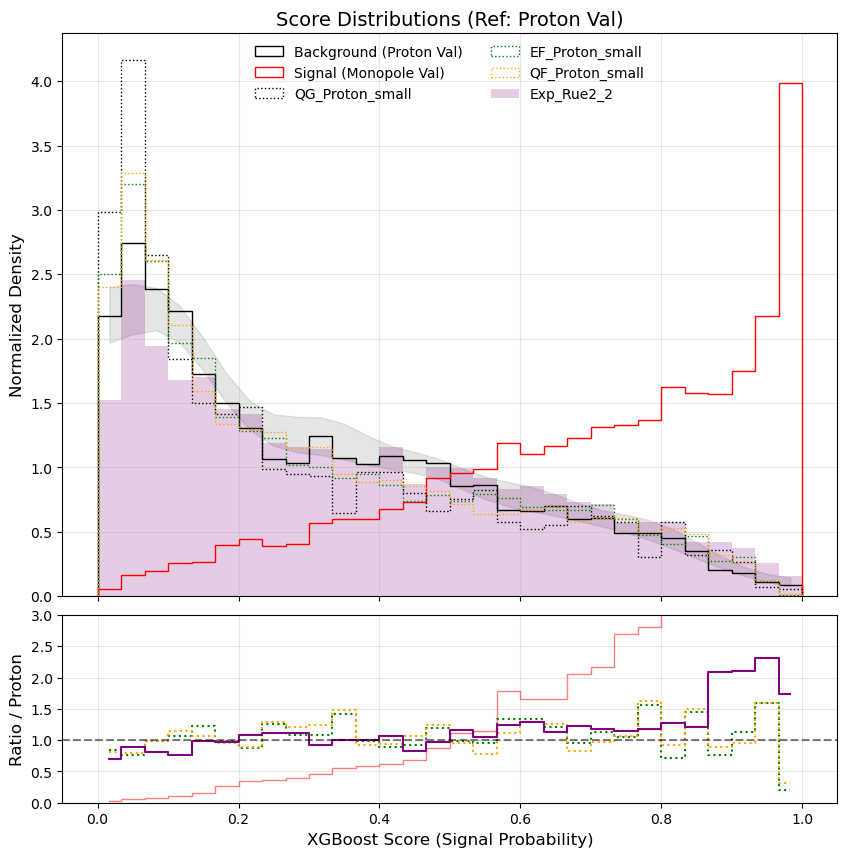

Plot saved to: /home/zhonghua/Filt_Event/UpperLimit/uncertainty/xgb_classify/score_distribution_with_ratio.png

Processing complete.
Example output (Validation head):
       rec_theta      Eage        weight     score  label
20910   0.652625  1.042539  3.301263e-10  0.476544      1
13859   0.498894  0.983287  3.585547e-10  0.578073      1
21574   0.723158  1.050881  3.147197e-10  0.704310      1
40338   0.104444  1.081063  4.273101e-10  0.522480      1
17153   0.673634  1.097192  3.242390e-10  0.903093      1


In [ ]:
# 4. 训练 XGBoost
# 会自动进行训练权重归一化，并对所有数据打分
model, processed_data = train_and_predict(all_data, features, model_type='xgb')


# 5. 画图
# 使用物理权重画图
plot_weighted_scores(processed_data, output_dir, bin_num=30)

# 6. 获取结果
# 此时 processed_data['val'], processed_data['tests']['EF_Proton_small'] 等
# 已经是包含 'score' 列的完整 DataFrame 了
print("\nProcessing complete.")
print("Example output (Validation head):")
print(processed_data['val'][['rec_theta', 'Eage', 'weight', 'score', 'label']].head())




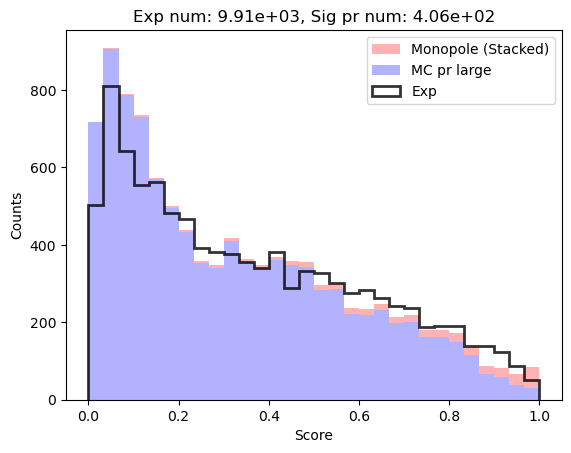

In [99]:
# 如果你想获取特定的 DataFrame 进行后续操作：
df_val_result = processed_data['val']
sig_df_val_result = df_val_result[df_val_result['label'] == 1]
bkg_df_val_result = df_val_result[df_val_result['label'] == 0]
df_ef_result = processed_data['tests']['EF_Proton_small']
df_qf_result = processed_data['tests']['QF_Proton_small']
df_qg_result = processed_data['tests']['QG_Proton_small']
df_rue_result = processed_data['tests']['Exp_Rue2_2']

bin_num=30
mc_pr_num=bkg_df_val_result['weight'].sum(); exp_pr_num=df_rue_result['weight'].sum(); re_scaled=exp_pr_num/mc_pr_num
sig_pr_num=sig_df_val_result['weight'].sum(); 
times=356*86400

# 准备数据和权重列表
data_list = [bkg_df_val_result['score'], sig_df_val_result['score']]
weights_list = [
    bkg_df_val_result['gaisser_weight'] * re_scaled * times,
    sig_df_val_result['weight'] * times * 5
]
labels_list = ['MC pr large', 'Monopole (Stacked)']

# 绘制堆叠直方图
# 注意：histtype='step' 在 stacked=True 时可能重合，建议用 'stepfilled' 或 'bar'
plt.hist(data_list, 
         weights=weights_list, 
         bins=bin_num, 
         range=(0,1), 
         stacked=True, 
         histtype='stepfilled', 
         alpha=0.3,
         label=labels_list,
         color=['blue', 'red']) # 为区分，建议手动指定颜色

# 绘制 Exp 作为对比（不参与堆叠）
plt.hist(df_rue_result['score'], 
         weights=df_rue_result['weight'] * times,  
         bins=bin_num, 
         range=(0,1),
         alpha=0.8, 
         histtype='step', 
         color='black',
         linewidth=2,
         label="Exp")

plt.legend()
# plt.yscale('log') # 物理实验通常需要对数坐标看尾部
plt.xlabel('Score')
plt.ylabel('Counts')
plt.title(f"Exp num: {exp_pr_num*times:.2e}, Sig pr num: {sig_pr_num*times*5:.2e}")
plt.show()


30 30
30 30


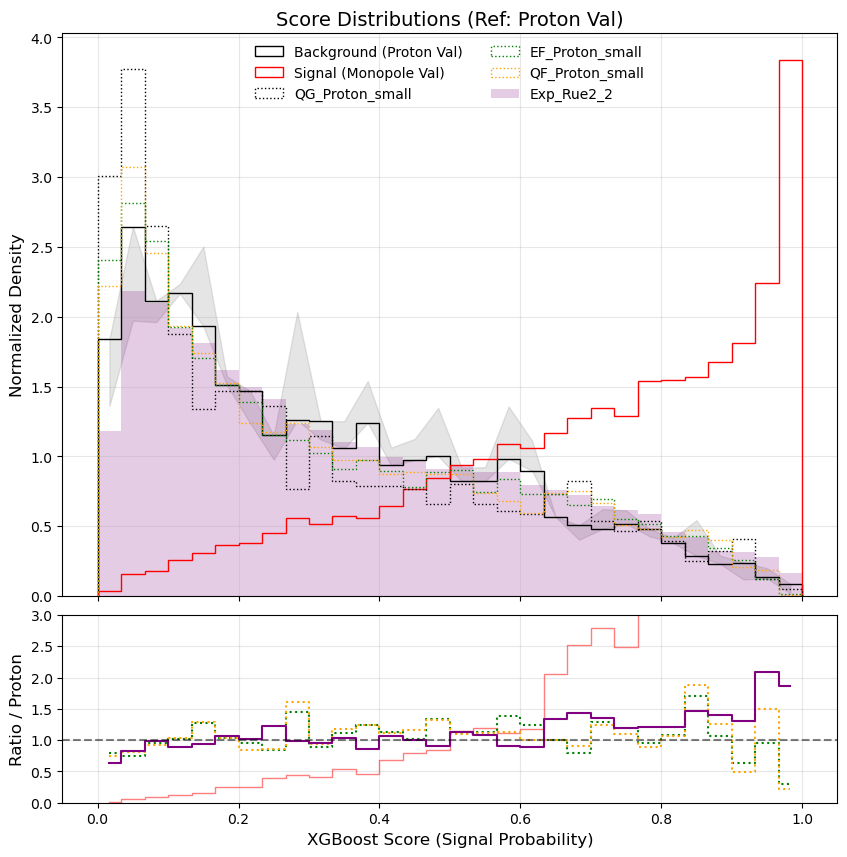

Plot saved to: /home/zhonghua/Filt_Event/UpperLimit/uncertainty/xgb_classify/score_distribution_with_ratio.png

Processing complete.
Example output (Validation head):
       rec_theta      Eage        weight     score  label
33978   0.721587  0.985624  3.147197e-10  0.861007      1
24575   0.184073  0.983980  4.188622e-10  0.846893      1
48006   0.393595  1.025218  3.841460e-10  0.651866      1
27575   0.295166  1.072132  4.050000e-10  0.522893      1
18940   0.445148  0.934737  3.683281e-10  0.534453      1


In [63]:
def plot_weighted_scores(datasets, output_dir, bin_num=50):
    """
    画加权后的 Score 分布图 (含 Ratio 子图，以 Proton Val 为基准)
    """
    os.makedirs(output_dir, exist_ok=True)
    
    # 提取数据
    df_val = datasets['val']
    
    # Sig (Val)
    val_sig = df_val[df_val['label'] == 1]
    # Bkg (Val - Proton Baseline)
    val_bkg = df_val[df_val['label'] == 0]
    
    # 设置 Bins
    
    bins = np.linspace(0, 1, bin_num + 1)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    
    # 创建画布：两个子图 (Main + Ratio)
    # height_ratios=[3, 1] 让主图占 3/4，Ratio 占 1/4
    # hspace=0.05 让两个图紧贴在一起
    fig, (ax_main, ax_ratio) = plt.subplots(
        2, 1, 
        figsize=(10, 10), 
        sharex=True, 
        gridspec_kw={'height_ratios': [3, 1], 'hspace': 0.05}
    )
    
    # ==============================
    # 1. 计算基准 (Background Val)
    # ==============================
    # 计算 Proton Val 的直方图 (density=True)
    hist_bkg, _ = np.histogram(val_bkg['score'], bins=bins, weights=val_bkg['weight'], density=True)
    
    # 处理分母为0的情况，避免除法报错 (将0替换为nan)
    hist_base = hist_bkg.copy()
    hist_base[hist_base == 0] = np.nan 
    
    

    # 画基准线 (Main Plot)
    ax_main.hist(bins[:-1], bins, weights=hist_bkg, 
                 histtype='step', color='black', lw=2, label='Background (Proton Val)', linestyle='-')
    
    # ==============================
    # 2. 画 Signal (Val)
    # ==============================
    hist_sig, _ = np.histogram(val_sig['score'], bins=bins, weights=val_sig['weight'], density=True)
    
    # Main Plot
    ax_main.hist(bins[:-1], bins, weights=hist_sig, 
                 histtype='step', color='red', lw=2, label='Signal (Monopole Val)', linestyle='-')
    
    # Ratio Plot (Sig / Bkg) 
    # 虽然物理上 Sig/Bkg 意义不同，但这里为了看分布形状差异，也画出来
    ratio_sig = hist_sig / hist_base
    ax_ratio.step(bin_centers, ratio_sig, where='mid', color='red', lw=1, alpha=0.5, linestyle='-')

    # ==============================
    # 3. 画 Test Sets并计算 Ratio
    # ==============================
    colors = ['blue', 'green', 'orange', 'purple', 'magenta']
    test_sets = datasets['tests']
    # small QG
    hist_QG = np.histogram(test_sets['QG_Proton_small']['score'], bins=bins, weights=test_sets['QG_Proton_small']['weight'], density=True)[0]
    hist_QG[hist_QG == 0] = np.nan # 处理分母为0的情况

    ratio_small_diffs = {'QF_Proton_small': [], 'EF_Proton_small': [], 'QG_Proton_small': np.ones(bin_num)}

    for i, (name, df) in enumerate(test_sets.items()):
        c = colors[i % len(colors)]
        
        # 计算当前数据的直方图 (density=True)
        hist_curr, _ = np.histogram(df['score'], bins=bins, weights=df['weight'], density=True)
        
        # Main Plot
        linestyle = ':'; histtype = 'step'; alpha=1
        if name not in ['QG_Proton_small', 'EF_Proton_small', 'QF_Proton_small']:
            linestyle = '-'; histtype = 'stepfilled'; alpha=0.2
        if name == 'QG_Proton_small':
            c='black'

        if name in ['QF_Proton_small', 'EF_Proton_small']:
            ratio = hist_curr / hist_QG
            print(len(hist_curr), bin_num)
            ax_main.hist(bins[:-1], bins, weights=hist_curr, 
                     histtype=histtype, linestyle=linestyle, color=c, label=f'{name}', alpha=alpha, lw=1.5)
            # Ratio Plot (Current / Proton_Val)
            ax_ratio.step(bin_centers, ratio, where='mid', color=c, lw=1.5, linestyle=linestyle,)
            ratio_small_diffs[name]= ratio

        elif name == 'QG_Proton_small':
            ax_main.hist(bins[:-1], bins, weights=hist_curr, 
                        histtype=histtype, linestyle=linestyle, color=c, label=f'{name}', alpha=alpha, lw=1.5)
        else:
            ratio = hist_curr / hist_base
            ax_main.hist(bins[:-1], bins, weights=hist_curr, 
                     histtype=histtype, linestyle=linestyle, color=c, label=f'{name}', alpha=alpha, lw=1.5)
            # Ratio Plot (Current / Proton_Val)
            ax_ratio.step(bin_centers, ratio, where='mid', color=c, lw=1.5, linestyle=linestyle,)

    arr_qf = np.asarray(ratio_small_diffs.get('QF_Proton_small', np.ones(bin_num)), dtype=float)
    arr_ef = np.asarray(ratio_small_diffs.get('EF_Proton_small', np.ones(bin_num)), dtype=float)
    arr_qg = np.asarray(ratio_small_diffs.get('QG_Proton_small', np.ones(bin_num)), dtype=float)

    # 2. 处理 nan 值为 0 (或者 1，取决于你的物理理解，这里用 0 避免异常带)
    arr_qf = np.nan_to_num(arr_qf, nan=0.0)
    arr_ef = np.nan_to_num(arr_ef, nan=0.0)
    arr_qg = np.nan_to_num(arr_qg, nan=0.0)

    # 3. 计算包络
    combined = np.array([arr_qf, arr_ef, arr_qg])
    max_array = np.max(combined, axis=0)
    min_array = np.min(combined, axis=0)
    
    # 4. 计算物理边界值，并再次强制转换类型
    # 这一步非常重要，防止 hist_bkg 含有 object 类型导致结果变成 object 数组
    hist_bkg_min = (np.asarray(hist_bkg, dtype=float) * min_array).astype(float)
    hist_bkg_max = (np.asarray(hist_bkg, dtype=float) * max_array).astype(float)
    x = np.asarray(bin_centers, dtype=float)
    y_min = np.asarray(hist_bkg_min, dtype=float)
    y_max = np.asarray(hist_bkg_max, dtype=float)

    # 绘图：去掉 step='post'，使用 bin_centers
    ax_main.fill_between(
        x, 
        y_min, 
        y_max, 
        color='gray', 
        alpha=0.2, 
        # label='Model Uncertainty',
        zorder=0  # 放在底层
    )
    # ax_main.fill_between(bins, 
    #                      np.append(hist_bkg_min, hist_bkg_min[-1]), 
    #                      np.append(hist_bkg_max, hist_bkg_max[-1]), 
    #                      step='post', color='gray', alpha=0.3, label='Model Uncertainty')
    # ax_main.fill_between(bins[:-1], hist_bkg_min, hist_bkg_max, step='post', color='gray', alpha=0.2, label='Model Uncertainty')
    # ==============================
    # 4. 装饰与保存
    # ==============================
    
    # --- Main Ax setting ---
    ax_main.set_ylabel("Normalized Density", fontsize=12)
    ax_main.set_title("Score Distributions (Ref: Proton Val)", fontsize=14)
    # ax_main.set_yscale('log') # 如果需要对数坐标，请取消注释
    
    # 将 Legend 放在主图内部或上方，避免遮挡
    ax_main.legend(loc='upper center', bbox_to_anchor=(0.5, 1.0), ncol=2, frameon=False, fontsize=10)
    ax_main.grid(alpha=0.3)
    
    # --- Ratio Ax setting ---
    ax_ratio.axhline(1, color='black', linestyle='--', alpha=0.5) # y=1 基准线
    ax_ratio.set_ylabel("Ratio / Proton", fontsize=12)
    ax_ratio.set_xlabel("XGBoost Score (Signal Probability)", fontsize=12)
    
    # 设置 Ratio 的 y 轴范围，防止极值拉伸 (例如 0 到 3)
    ax_ratio.set_ylim(0, 3.0) 
    ax_ratio.grid(alpha=0.3)
    
    save_path = os.path.join(output_dir, 'score_distribution_with_ratio.png')
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    # plt.close() # 关闭图像释放内存
    print(f"Plot saved to: {save_path}")


# 5. 画图
# 使用物理权重画图
plot_weighted_scores(processed_data, output_dir, bin_num=30)

# 6. 获取结果
# 此时 processed_data['val'], processed_data['tests']['EF_Proton_small'] 等
# 已经是包含 'score' 列的完整 DataFrame 了
print("\nProcessing complete.")
print("Example output (Validation head):")
print(processed_data['val'][['rec_theta', 'Eage', 'weight', 'score', 'label']].head())

# 如果你想获取特定的 DataFrame 进行后续操作：
df_val_result = processed_data['val']
df_ef_result = processed_data['tests']['EF_Proton_small']
# ...


In [49]:
import numpy as np
import os

# 加载数据
data = np.load("/home/zhonghua/data/Dataset_Filted/Simulation/1e10_V04/Proton_combined_filted_1e10_V04_dataset_muon.npz", allow_pickle=True)
params = data['params']
param_names = data['param_names']
HitsM = data['hitsM']
HitsE = data['hitsE']

# 获取数据总数
n_samples = len(params)
print(f"总样本数: {n_samples}")

# 生成随机索引（不打乱原始顺序的版本）
np.random.seed(33)  # 设置随机种子保证可重复性
all_indices = np.arange(n_samples)
np.random.shuffle(all_indices)  # 打乱索引

# 计算分割点
split_point = int(n_samples * 0.2)

# 获取20%的索引（测试集）
test_indices = all_indices[:split_point]
# 获取80%的索引（训练集）
train_indices = all_indices[split_point:]

print(f"测试集样本数: {len(test_indices)} ({len(test_indices)/n_samples*100:.1f}%)")
print(f"训练集样本数: {len(train_indices)} ({len(train_indices)/n_samples*100:.1f}%)")

# 分割数据
params_test = params[test_indices]
HitsM_test = HitsM[test_indices]
HitsE_test = HitsE[test_indices]

params_train = params[train_indices]
HitsM_train = HitsM[train_indices]
HitsE_train = HitsE[train_indices]

# 保存测试集（20%数据）
test_file = "/home/zhonghua/data/Dataset_Filted/Simulation/1e10_V04/Proton_combined_filted_1e10_V04_dataset_muon_test_20pct.npz"
np.savez(test_file, 
         params=params_test,
         param_names=param_names,
         hitsM=HitsM_test,
         hitsE=HitsE_test,
         indices=test_indices)  # 可选：保存索引以便追溯
print(f"测试集已保存到: {test_file}")

# 保存训练集（80%数据）
train_file = "/home/zhonghua/data/Dataset_Filted/Simulation/1e10_V04/Proton_combined_filted_1e10_V04_dataset_muon_train_80pct.npz"
np.savez(train_file,
         params=params_train,
         param_names=param_names,
         hitsM=HitsM_train,
         hitsE=HitsE_train,
         indices=train_indices)  # 可选：保存索引
print(f"训练集已保存到: {train_file}")

# 验证数据形状
print("\n验证数据形状:")
print(f"原始数据 - params: {params.shape}, HitsM: {HitsM.shape}, HitsE: {HitsE.shape}")
print(f"测试集  - params: {params_test.shape}, HitsM: {HitsM_test.shape}, HitsE: {HitsE_test.shape}")
print(f"训练集  - params: {params_train.shape}, HitsM: {HitsM_train.shape}, HitsE: {HitsE_train.shape}")

# 验证数据是否没有重叠
test_set = set(test_indices)
train_set = set(train_indices)
print(f"\n验证分割是否正确:")
print(f"测试集和训练集是否有重叠: {bool(test_set & train_set)}")
print(f"总索引数: {len(test_set | train_set)} (应与总样本数一致)")

# 可选：保存一个包含所有信息的元数据文件
metadata = {
    'original_file': "/home/zhonghua/data/Dataset_Filted/Simulation/1e10_V04/Proton_combined_filted_1e10_V04_dataset_muon.npz",
    'total_samples': n_samples,
    'test_samples': len(test_indices),
    'train_samples': len(train_indices),
    'test_percentage': 20.0,
    'train_percentage': 80.0,
    'random_seed': 42
}
np.savez("/home/zhonghua/data/Dataset_Filted/Simulation/1e10_V04/split_metadata.npz", **metadata)
print(f"\n元数据已保存到: /home/zhonghua/data/Dataset_Filted/Simulation/1e10_V04/split_metadata.npz")


总样本数: 218095
测试集样本数: 43619 (20.0%)
训练集样本数: 174476 (80.0%)
测试集已保存到: /home/zhonghua/data/Dataset_Filted/Simulation/1e10_V04/Proton_combined_filted_1e10_V04_dataset_muon_test_20pct.npz
训练集已保存到: /home/zhonghua/data/Dataset_Filted/Simulation/1e10_V04/Proton_combined_filted_1e10_V04_dataset_muon_train_80pct.npz

验证数据形状:
原始数据 - params: (218095, 30), HitsM: (218095,), HitsE: (218095,)
测试集  - params: (43619, 30), HitsM: (43619,), HitsE: (43619,)
训练集  - params: (174476, 30), HitsM: (174476,), HitsE: (174476,)

验证分割是否正确:
测试集和训练集是否有重叠: False
总索引数: 218095 (应与总样本数一致)

元数据已保存到: /home/zhonghua/data/Dataset_Filted/Simulation/1e10_V04/split_metadata.npz
